In [8]:
from cellpose.models import Cellpose
from hcrp import *
from skimage.io import imread
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from IPython import get_ipython
ipython = get_ipython()
if ipython.execution_count == 1:
    os.chdir('..') # because kernel initiates in scripts folder, only runs on first import
%matplotlib qt

In [2]:
# CHANGE TO PATH
folder = f"{get_path('dropbox.txt')}/Anqi/Intership/AI_segmentation/Dataset3_tkv_dad_dpp_Nuclei/"
filename = "Td_Hoechst_dad488_dpp546_tkv647_20240521_Embryo05_T1.tif"
label_location = "data/SilverFish_Pilot"
channel_names = ["tkv", "dpp", "dad", "nuclear"]

channel_types = ["hcr", "hcr", "hcr", "nuclear"]
results_path = f"data/{filename.split('.')[0]}_results"
# EDIT HCR PARAMETERS IF NEEDED
tkv_params = DEFAULT_HCR_PARAMS.copy()
stack = imread(f"{folder}/{filename}")
n_z = stack.shape[0]
tkv_params["dot_intensity_thresh"] = np.percentile(stack[n_z//2, :, :, 0].flatten(), 60)
tkv_params["verbose"] = False
dpp_params = DEFAULT_HCR_PARAMS.copy()
dpp_params["dot_intensity_thresh"] = None
dad_params = DEFAULT_HCR_PARAMS.copy()
dad_params["dot_intensity_thresh"] = None
hcr_params = [tkv_params, dpp_params, dad_params, None]

In [9]:
# CHANGE TO PATH
folder = f"{get_path('dropbox.txt')}/Anqi/Intership/AI_segmentation/Dataset4_dad_dpp_pMad_Nuclei/"
filename = "Td_Hoechst_pMad488_dpp546_dad647_20240522_Embryo02_T1.tif"
label_location = "data/SilverFish_Pilot"
channel_names = ["dad", "dpp", "pmad", "nuclear"]
channel_types = ["hcr", "hcr", "staining", "nuclear"]
results_path = f"data/{filename.split('.')[0]}_results"
# EDIT HCR PARAMETERS IF NEEDED
params = DEFAULT_HCR_PARAMS.copy()
stack = imread(f"{folder}/{filename}")
n_z = stack.shape[0]
params["dot_intensity_thresh"] = np.percentile(stack[n_z//2, :, :, 0].flatten(), 60)
params["sigma_blur"] = 1
params["verbose"] = False
dpp_params = params.copy()
dpp_params["dot_intensity_thresh"] = None
dpp_params["sigma_blur"] = 1
hcr_params = [dpp_params, dpp_params, None, None]

In [10]:
# RUN THE CODE
# for some reason the matplotlib labelling doesn't work in notebooks. Use label.py to label.
midline, contour, background, z_midline, endoderm = load_labels_safe(
    folder, label_location, filename
)
z = z_midline 
stack = imread(f"{folder}/{filename}")
masks, cell_data, hcr_data = process_layer(
    z,
    folder,
    filename,
    label_location,
    results_path=results_path,
    channel_names=channel_names,
    channel_types=channel_types,
    hcr_params=hcr_params,
)

Saved results to data/Td_Hoechst_pMad488_dpp546_dad647_20240522_Embryo02_T1_results


In [11]:
# PLOT THE HCR RESULTS 
%matplotlib qt
for i, (cname, ctype) in enumerate(zip(channel_names, channel_types)):
    if ctype=="hcr":
        fig, ax = plot_hcr(hcr_data[i], stack[z, :, :, i])
        ax[0].set(title=f"Layer {z}, {filename[-20:]}: {cname}")
        plt.show()

In [12]:
# PLOT ALLOCATION
%matplotlib qt
for i, (cname, ctype) in enumerate(zip(channel_names, channel_types)):
    if ctype=="hcr":
        fig, ax = plot_hcr_cell_projection(hcr_data[i], cell_data, masks, stack[z, :, :, i])
        ax.set(title=f"Layer {z}, {filename[-20:]}: {cname}")
        plt.show()

In [13]:
# PLOT ENDODERM
plot_cell_property(cell_data, stack[z, :, :, 3], "endoderm")

(<Figure size 1280x960 with 1 Axes>,
 <Axes: title={'center': 'Cell Property: endoderm'}>)

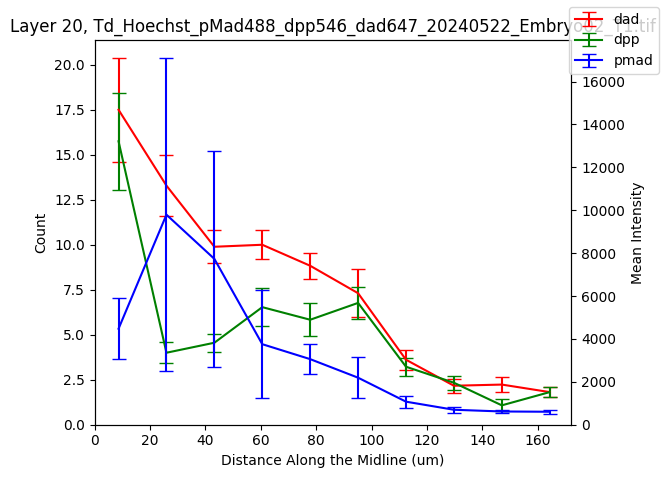

In [14]:
# PLOT GRADIENTS in all cells
%matplotlib inline
fig, ax = plot_gradients(channel_names, channel_types, cell_data, pixel_to_mu=1/2.8906, err_type="std_err", bin_size=50)
ax.set(title=f"Layer {z}, {filename}")  
plt.tight_layout()
plt.savefig(f"{results_path}/{filename.split('.')[0]}_gradients.pdf")

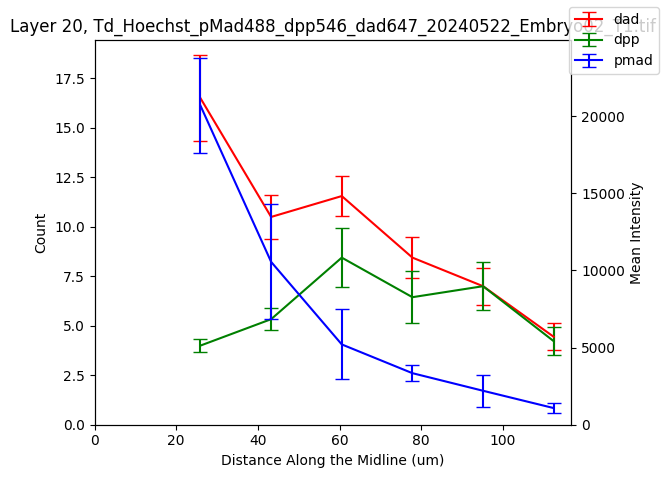

In [16]:
# PLOT GRADIENTS 
%matplotlib inline
fig, ax = plot_gradients(channel_names, channel_types, cell_data[cell_data["endoderm"]], pixel_to_mu=1/2.8906, err_type="std_err", bin_size=50)
ax.set(title=f"Layer {z}, {filename}")  
plt.tight_layout()
plt.savefig(f"{results_path}/{filename.split('.')[0]}_gradients.pdf")

In [17]:
# RUN FOR MULTIPLE Z
midline, contour, background, z_midline, endoderm = load_labels_safe(
    folder, label_location, filename
)
z = z_midline 
stack = imread(f"{folder}/{filename}")
z_range = np.array((range(z_midline-2, z_midline+3)))
cell_datas = []
for z in z_range:
    print(f'Running z = {z}')
    masks_z, cell_data_z, hcr_data_z = process_layer(
        z,
        folder,
        filename,
        label_location,
        results_path=None,
        channel_names=channel_names,
        channel_types=channel_types,
        hcr_params=hcr_params,
        diameter=30,
    )
    cell_datas.append(cell_data_z)
cell_data_multi = pd.concat(cell_datas, ignore_index=True)
cell_data_multi.to_csv(f"{results_path}/{filename.split('.')[0]}_cell_data.csv")

Running z = 18
Running z = 19
Running z = 20
Running z = 21
Running z = 22


(<Figure size 640x480 with 3 Axes>,
 array([<Axes: ylabel='dad Count'>, <Axes: ylabel='dpp Count'>,
        <Axes: xlabel='Distance Along the Midline (um)', ylabel='pmad Mean Intensity'>],
       dtype=object))

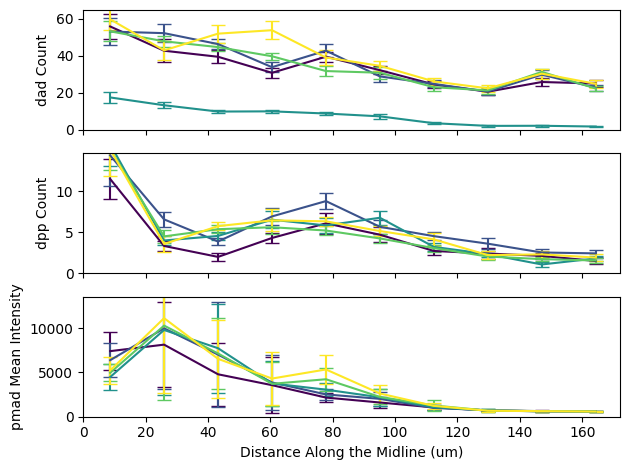

In [19]:
%matplotlib inline
plot_layer_gradients(z_range, channel_names, channel_types, cell_data_multi, pixel_to_mu=1/2.8906, err_type="std_err")

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Distance Along the Midline (um)', ylabel='Count'>)

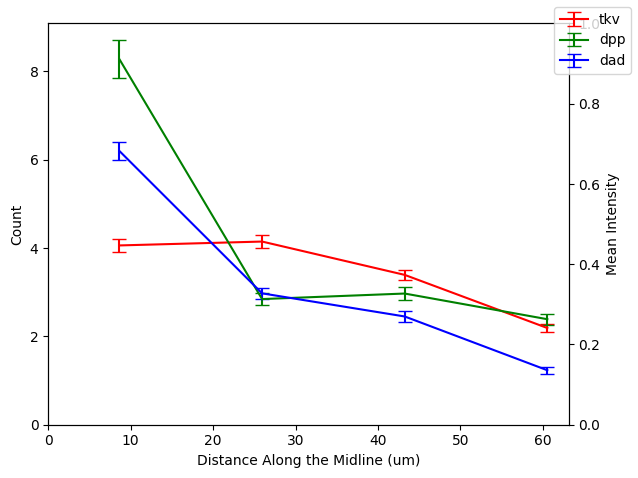

In [8]:

plot_gradients( channel_names, channel_types, cell_data_multi, pixel_to_mu=1/2.8906, err_type="std_err")

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Cell Property: endoderm'}>)

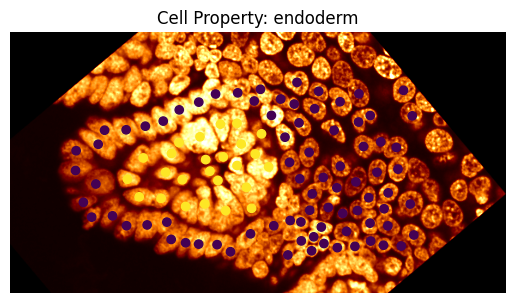

In [19]:
%matplotlib inline
z = 9
plot_cell_property(cell_data_multi[cell_data_multi["z"]==z], stack[z, :, :, 3], "endoderm")

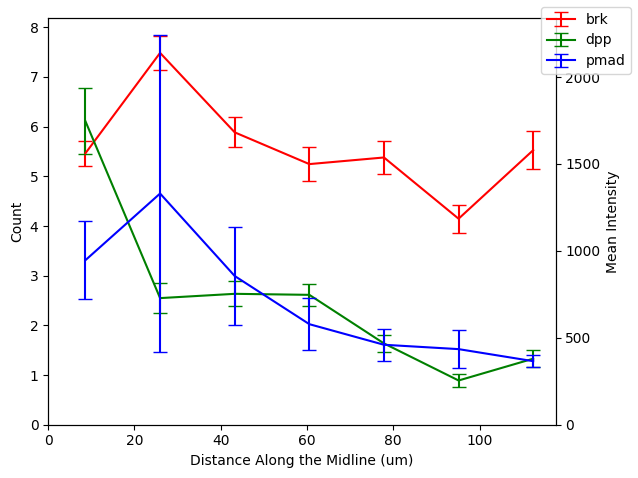

In [77]:
%matplotlib inline
fig, ax = plot_gradients(channel_names, channel_types, cell_data_multi, pixel_to_mu=1/2.8906, err_type="std_err")
# ax.set(title=f"Layer {z_range[0]}-{z_range[-1]}, {filename}")
# plt.tight_layout()

In [78]:
%matplotlib qt
plot_hcr_cell_projection(hcr_data_z[1], cell_data_z, masks_z, stack[z, :, :, 3])

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [79]:
plt.imshow(stack[z, :, :, 3], cmap="gray")
plt.imshow(masks_z, cmap=get_random_cmap(masks_z.max()+1), alpha=0.3)

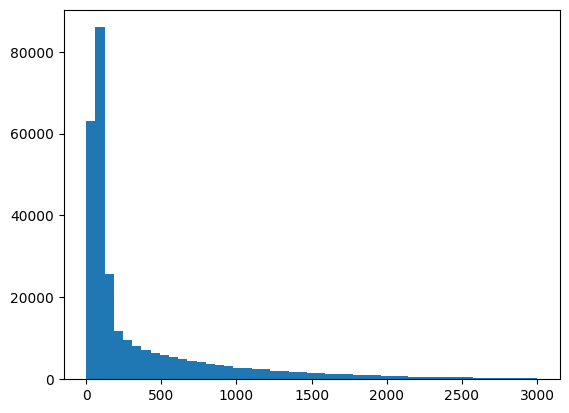

In [57]:
folder = f"{get_path('dropbox.txt')}/Anqi/Intership/AI_segmentation/Dataset1_brk_dpp_pMad_Nuclei/Limb_Ext_Stg01"
filename = "Stg01_Emb03_T102.tif"
stack = imread(f"{folder}/{filename}")
z = 10
hist = plt.hist(stack[z,:,:,0].flatten(), bins=np.linspace(0,3000))